# Определение выгодного тарифа для телеком-компании

У сотовой компании два тарифных плана: «Смарт» и «Ультра». Необходимо понять, какой тариф приносит больший доход. На небольшой выборке клиентов необходимо провести анализ: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно сделать вывод — какой тариф лучше.

## Изучение данных из файлов

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats as st

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
users = pd.read_csv('/datasets/users.csv',  parse_dates=['churn_date', 'reg_date']) 
display(users.head())
display(users.describe().T)
print('************************************************')
print(users.isna().mean())
print('************************************************')
users.info()
users['tariff'].unique()
users['age'].sort_values().unique()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


************************************************
user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64
************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

Видим 500 строк с пользователями.
* Пустые значения только в столбце churn_date, что допустимо. Большинство пользователей не меняли тариф.
* В столбце возраста все в порядке. Его границы от 18 до 75.
* В столбце тариф видим только 2 тарифа, как и ожидалось.
* С городами тоже порядок. Нет пропусков и опечаток.
* Проблемы только с типами данных. Необходимо перевести churn_date и reg_date в datetime.

In [4]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date']) 
display(calls.head())
display(calls.describe().T)
print('************************************************')
print(calls.isna().mean())
print('************************************************')
print(calls.query('duration == 0').count())
print('************************************************')
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


************************************************
id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64
************************************************
id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64
************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


* Здесь так же видна необходимость поменять тип данных call_date. 
* Большое количество (39613 строк) несостоявшихся звонков.
* Все звонки округлим в большую сторону. Ведь политика компании такова: "Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута"
* Поэтому duration переведем в int.

In [5]:
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date']) 
display(messages.head())
display(messages.describe().T)
print('************************************************')
print(messages.isna().mean())
print('************************************************')
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


************************************************
id              0.0
message_date    0.0
user_id         0.0
dtype: float64
************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


* Здесь только меняем типы данных у столбцов id и message_date.

In [28]:
internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'], index_col=0) 
display(internet.head())
display(internet.describe().T)
print('************************************************')
print(internet.isna().mean())
print('************************************************')
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,count,mean,std,min,25%,50%,75%,max
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


************************************************
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64
************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


* Здесь меняем типы данных в столбцах id и session_date.
* Столбец "Unnamed: 0" можно удалить, он полностью дублирует индексы таблицы.
* 19598 строк с нулевым трафиком, это седьмая часть всей таблицы. Пропуски могут быть связаны с технической ошибкой заполнения таблицы, а могут говорить о том, что пользователь не успел израсходовать трафик и прервал сессию. Бужем склоняться ко второму варианту.

In [7]:
tariffs = pd.read_csv('/datasets/tariffs.csv') 
display(tariffs.head())
display(tariffs.describe().T)
print('************************************************')
print(tariffs.isna().mean())
print('************************************************')
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


************************************************
messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64
************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


* Здесь нужно добавить столбец gb_per_month_included - сколько Гигабайт трафика включено в тариф.

### Вывод

Общий вывод: 
    
    в большинстве таблиц заменяем типы данных у некоторых столбцов, 
    
    а также удаляем дублирующий индексы столбец "Unnamed: 0" в таблице internet.
    
    Пропуски данных не обнаружены.    

## Предобработка данных

In [8]:
# меняем типы данных
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int')

messages['id'] = messages['id'].astype('int')

# в internet удалим столбец Unnamed: 0
internet.drop(columns='Unnamed: 0', axis=1, inplace=True, errors='ignore')
internet['id'] = internet['id'].astype('int')

# в tariffs добавим столбец gb_per_month_included
tariffs['gb_per_month_included'] = np.ceil(tariffs['mb_per_month_included'] / 1024)

Здесь выполнено то, что было запланировано в предыдущем разделе.

In [9]:
# добавим в таблицу calls столбец месяц для последующих расчетов
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

# посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам
calls_in_month = calls.groupby(['user_id','month'])['duration'].agg\
    (
        {
            'duration': ['count', 'sum']
        }
    ).reset_index()
calls_in_month.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
display(calls_in_month)

,user_id,month,calls_count,calls_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


Мы создали датафрейм, отражающий для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.

In [10]:
# добавим в таблицу messages столбец месяц для последующих расчетов
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

# посчитаем количество отправленных сообщений по месяцам
messages_in_month = messages.groupby(['user_id','month'])['message_date'].count().reset_index()
messages_in_month.columns = ['user_id', 'month', 'msg_count']
display(messages_in_month)

,user_id,month,msg_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Этот датафрейм показывает количество отправленных сообщений по месяцам.

In [11]:
# добавим в таблицу calls столбец месяц для последующих расчетов
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

# посчитаем объем израсходованного интернет-трафика по месяцам
internet_in_month = internet.groupby(['user_id','month'])['mb_used'].sum().round().reset_index()
internet_in_month.columns = ['user_id', 'month', 'internet_sum']
internet_in_month['internet_sum_gb'] = np.ceil(internet_in_month['internet_sum'] / 1024)
display(internet_in_month)

,user_id,month,internet_sum,internet_sum_gb
0,1000,5,2253.0,3.0
1,1000,6,23234.0,23.0
2,1000,7,14004.0,14.0
3,1000,8,14056.0,14.0
4,1000,9,14569.0,15.0
...,...,...,...,...
3198,1498,10,20579.0,21.0
3199,1499,9,1846.0,2.0
3200,1499,10,17789.0,18.0
3201,1499,11,17963.0,18.0


* Создали датафрейм объемом израсходованного интернет-трафика по месяцам. 
* Дополнили столбцом, округлив число использованных Гигабайт трафика, согласно политике "Мегалайна":"Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта."

In [12]:
# объединим полученные датафреймы в один
total_in_month = calls_in_month.merge(messages_in_month[['user_id', 'month', 'msg_count']],  how='outer', on=['user_id', 'month'])
total_in_month = total_in_month.merge(internet_in_month[['user_id', 'month', 'internet_sum', 'internet_sum_gb']], how='outer', on=['user_id', 'month'])

In [13]:
# дополним total_in_month данными о тарифах
total_in_month = total_in_month.merge(users[['user_id','city','tariff']], on='user_id')
total_in_month = total_in_month.rename(columns={'tariff': 'tariff_name'})

total_in_month = total_in_month.merge(
    tariffs[
        ['tariff_name','minutes_included','rub_per_minute','messages_included',
         'rub_per_message','gb_per_month_included','rub_per_gb','rub_monthly_fee']
    ], on='tariff_name')

In [14]:
# пустые значения по использованным услугам заменим нулями
total_in_month.fillna(0, inplace=True)

In [15]:
# рассчитаем помесячную выручку с каждого пользователя 
total_in_month['calls_revenue'] = (total_in_month['calls_sum'] - total_in_month['minutes_included']) * total_in_month['rub_per_minute']
total_in_month.loc[total_in_month["calls_revenue"] < 0, "calls_revenue"] = 0

total_in_month['msg_revenue'] = (total_in_month['msg_count'] - total_in_month['messages_included']) * total_in_month['rub_per_message']
total_in_month.loc[total_in_month["msg_revenue"] < 0, "msg_revenue"] = 0

total_in_month['internet_revenue'] = (total_in_month['internet_sum_gb'] - total_in_month['gb_per_month_included']) * total_in_month['rub_per_gb']
total_in_month.loc[total_in_month["internet_revenue"] < 0, "internet_revenue"] = 0

total_in_month['total_revenue'] = total_in_month['calls_revenue'] + total_in_month['msg_revenue'] + total_in_month['internet_revenue'] + total_in_month['rub_monthly_fee']
display(total_in_month.info())
display(total_in_month[total_in_month['total_revenue'] > total_in_month['rub_monthly_fee']]) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
calls_count              3214 non-null float64
calls_sum                3214 non-null float64
msg_count                3214 non-null float64
internet_sum             3214 non-null float64
internet_sum_gb          3214 non-null float64
city                     3214 non-null object
tariff_name              3214 non-null object
minutes_included         3214 non-null int64
rub_per_minute           3214 non-null int64
messages_included        3214 non-null int64
rub_per_message          3214 non-null int64
gb_per_month_included    3214 non-null float64
rub_per_gb               3214 non-null int64
rub_monthly_fee          3214 non-null int64
calls_revenue            3214 non-null float64
msg_revenue              3214 non-null float64
internet_revenue         3214 non-null float64
total_revenue     

None

,user_id,month,calls_count,calls_sum,msg_count,internet_sum,internet_sum_gb,city,tariff_name,minutes_included,rub_per_minute,messages_included,rub_per_message,gb_per_month_included,rub_per_gb,rub_monthly_fee,calls_revenue,msg_revenue,internet_revenue,total_revenue
50,1024,11,157.0,1146.0,0.0,43107.0,43.0,Санкт-Петербург,ultra,3000,1,1000,1,30.0,150,1950,0.0,0.0,1950.0,3900.0
51,1024,12,136.0,949.0,0.0,35948.0,36.0,Санкт-Петербург,ultra,3000,1,1000,1,30.0,150,1950,0.0,0.0,900.0,2850.0
78,1050,7,35.0,209.0,52.0,35178.0,35.0,Тюмень,ultra,3000,1,1000,1,30.0,150,1950,0.0,0.0,750.0,2700.0
97,1060,12,184.0,1233.0,52.0,43931.0,43.0,Калуга,ultra,3000,1,1000,1,30.0,150,1950,0.0,0.0,1950.0,3900.0
211,1124,10,152.0,1225.0,121.0,49746.0,49.0,Махачкала,ultra,3000,1,1000,1,30.0,150,1950,0.0,0.0,2850.0,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,1499,12,69.0,492.0,66.0,13056.0,13.0,Пермь,smart,500,3,50,3,15.0,200,550,0.0,48.0,0.0,598.0
3210,1489,9,0.0,0.0,32.0,17206.0,17.0,Санкт-Петербург,smart,500,3,50,3,15.0,200,550,0.0,0.0,400.0,950.0
3211,1489,10,0.0,0.0,21.0,19559.0,20.0,Санкт-Петербург,smart,500,3,50,3,15.0,200,550,0.0,0.0,1000.0,1550.0
3212,1489,11,0.0,0.0,20.0,17492.0,18.0,Санкт-Петербург,smart,500,3,50,3,15.0,200,550,0.0,0.0,600.0,1150.0


### Вывод

Получен датафрейм _total_in_month_, где рассчитано:
* количество сделанных звонков и израсходованных минут разговора по месяцам(_calls_count и calls_sum_);
* количество отправленных сообщений по месяцам(_msg_count_);
* объем израсходованного интернет-трафика по месяцам(_internet_sum_gb Гбайт_);
* помесячная выручка с каждого пользователя (вычли бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножили на значение из тарифного плана; прибавили абонентскую плату, соответствующую тарифному плану).

Здесь 3214 строк. Основной ключ это пара _user_id_ и _month_. 

Каждая строка отражает, какой тариф был у пользователя в этом месяце, сколько он потратил минут разговора, отправил сообщений, израсходовал трафика, и сколько превысил этих значений по своему тарифу, сколько переплатил и за что.

Видим, что превысили лимит по трафику в 1796 случаях из 3214. Превышение обычно происходит в чем-то одном. Чаще это интеренет.

## Анализ данных

                   mean            var         std
              calls_sum      calls_sum   calls_sum
tariff_name                                       
smart        417.934948   36219.315784  190.313730
ultra        526.623350  100873.633397  317.606098


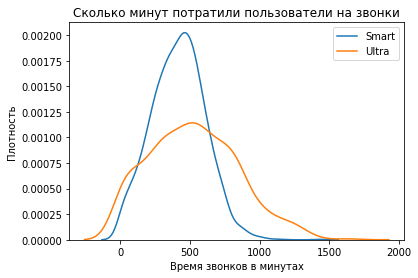

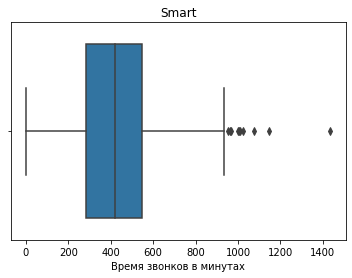

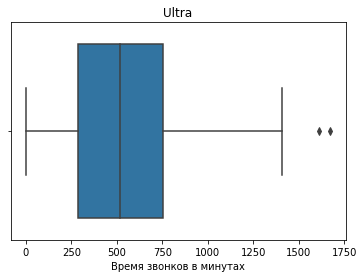

In [16]:
# рассмотрим минуты звонков
pvt = pd.pivot_table(
    total_in_month, values=['calls_sum'], index='tariff_name', aggfunc=[np.mean,np.var,np.std]
    )
print(pvt)

sns.distplot(
    total_in_month['calls_sum'][total_in_month['tariff_name']=='smart'],
    hist = False, kde = True, label='Smart')

sns.distplot(    
    total_in_month['calls_sum'][total_in_month['tariff_name']=='ultra'],
    hist = False, kde = True, label='Ultra')

plt.legend()
plt.xlabel('Время звонков в минутах')
plt.ylabel('Плотность')
plt.title('Сколько минут потратили пользователи на звонки')
plt.show()

sns.boxplot(x='calls_sum', data=(total_in_month[total_in_month['tariff_name']=='smart']))
plt.title('Smart')
plt.xlabel('Время звонков в минутах')
plt.show()
sns.boxplot(x='calls_sum', data=(total_in_month[total_in_month['tariff_name']=='ultra']))
plt.title('Ultra')
plt.xlabel('Время звонков в минутах')
plt.show()

* Посчитаны среднее количество минут разговоров, дисперсия и стандартное отклонение
* Гистограмма тарифа Smart показывает в большей степени нормальное распределение
* Гистограмма тарифа Ultra тоже близка к нормальному распределению, но ее плотность распределения ниже, а также она имеет скошенность вправо.
* Среднее в Ultra правее, чем в Smart. Это объясняется большим количеством включенных в абонентсвую плату минут.
* Стандартное отклонение больше у тарифа Ultra, из-за чего гистограмма более растянутая.
* Диаграммы размаха дают больше информации о скошенности, на них видны первый и третий квартили.

                  mean    median          var        std
             msg_count msg_count    msg_count  msg_count
tariff_name                                             
smart        33.384029      28.0   796.812958  28.227876
ultra        49.363452      38.0  2285.266143  47.804457


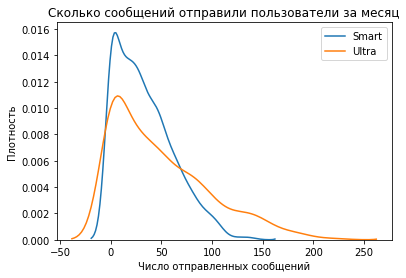

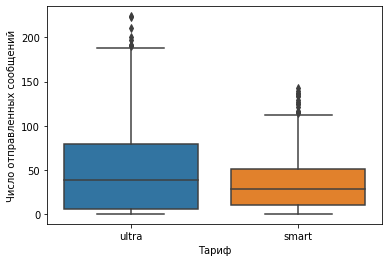

In [17]:
# рассмотрим количество отправленных сообщений
pvt = pd.pivot_table(
    total_in_month, values=['msg_count'], index='tariff_name', aggfunc=[np.mean,np.median,np.var,np.std]
    )
print(pvt)

sns.distplot(
    total_in_month['msg_count'][total_in_month['tariff_name']=='smart'],
    hist = False, kde = True, label='Smart')

sns.distplot(    
    total_in_month['msg_count'][total_in_month['tariff_name']=='ultra'],
    hist = False, kde = True, label='Ultra')

plt.legend()
plt.xlabel('Число отправленных сообщений')
plt.ylabel('Плотность')
plt.title('Сколько сообщений отправили пользователи за месяц')
plt.show()

sns.boxplot(data=total_in_month, x='tariff_name', y='msg_count')
plt.xlabel('Тариф')
plt.ylabel('Число отправленных сообщений')
plt.show()

* Здесь видим распределение, близкое к распределению Пуассона. 
* Поэтому больше пользы несет не среднее, а медианное значение. Среднее смещено влево.
* Стандартное отклонение большое.
* Здесь так же в Ultra плотность ниже, чем в Smart. Но и скошенность вправо сильнее.
* Диаграмма размаха показывает это наглядно.

                       mean             var             std
            internet_sum_gb internet_sum_gb internet_sum_gb
tariff_name                                                
smart             16.328847       33.028705        5.747061
ultra             19.494416       97.091686        9.853511


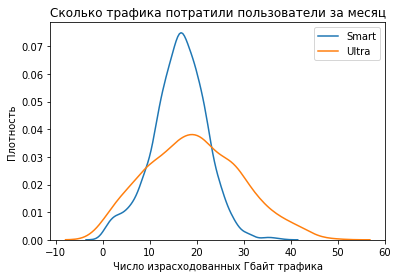

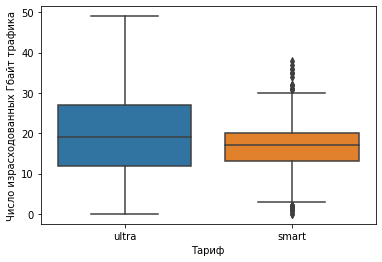

In [18]:
# рассмотрим трафик
pvt = pd.pivot_table(
    total_in_month, values=['internet_sum_gb'], index='tariff_name', aggfunc=[np.mean,np.var,np.std]
    )
print(pvt)

sns.distplot(
    total_in_month['internet_sum_gb'][total_in_month['tariff_name']=='smart'],
    hist = False, kde = True, label='Smart')

sns.distplot(    
    total_in_month['internet_sum_gb'][total_in_month['tariff_name']=='ultra'],
    hist = False, kde = True, label='Ultra')

plt.legend()
plt.xlabel('Число израсходованных Гбайт трафика')
plt.ylabel('Плотность')
plt.title('Сколько трафика потратили пользователи за месяц')
plt.show() 

sns.boxplot(data=total_in_month, x='tariff_name', y='internet_sum_gb')
plt.xlabel('Тариф')
plt.ylabel('Число израсходованных Гбайт трафика')
plt.show()

* Здесь оба распределения нормальные, но снова плотность Smarta выше, а Ultra немного смещен вправо. И разброс у него шире.

### Вывод

Мы получили средние, дисперсии и стандартные отклонения по 3 видам услуг.

Меньше всего стандартные отклонения в трафике, больше всего - в исходящих сообщениях. Поэтому там мы еще посчитали медианное среднее.

Ближе всего к нормальному распределение трафика, в звонках тоже распределение нормальное. А вот в сообщениях оно близко к Пуассоновскому.

Все 3 случая показали, что плотность распределения выше в тарифе Smart, а разброс данных, сдвиг медианы и скошенность вправо - в тарифе Ultra.

## Проверка гипотез

In [19]:
# Зададим уровень значимости 
alpha = 0.05
# Для исследуемой области этого достаточно.

### Первая гипотеза

**Нулевая гипотеза** - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются.

**Альтернативная гипотеза** - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

_Чтобы проверить равенство генеральных совокупностей с помощью t_теста, необходимо выполнение следуюзих условий:
1. Генеральные совокупности не должны зависеть друг от друга (да, наши выборки по тарифам не зависят друг от друга)
2. Выборочные средние должны быть нормально распределены (это мы проверим с помощью гистограмм)
3. Дисперсии рассматриваемых генеральных совокупностей должны быть равны (проверим. В случае разных дисперсий применим параметр equal_var = False)

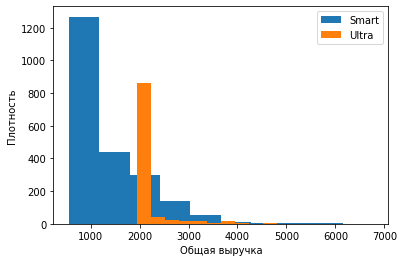

In [20]:
plt.hist(
    total_in_month['total_revenue'][total_in_month['tariff_name']=='smart'],
    label='Smart')

plt.hist(    
    total_in_month['total_revenue'][total_in_month['tariff_name']=='ultra'],
    label='Ultra')

plt.legend()
plt.xlabel('Общая выручка')
plt.ylabel('Плотность')
plt.show() 

Получили две скошенные вправо гистограммы. Попробуем принять эти распределения за нормальные.

In [21]:
# проверим средние, дисперсии и стандартные отклонения
pvt = pd.pivot_table(
    total_in_month, values=['total_revenue'], index='tariff_name', aggfunc=[np.mean,np.median,np.var,np.std]
    )
print(pvt)

# раз дисперсии сильно отличаются, передадим параметр equal_var = False
results = st.ttest_ind(
    total_in_month['total_revenue'][total_in_month['tariff_name']=='smart'], 
    total_in_month['total_revenue'][total_in_month['tariff_name']=='ultra'],
    equal_var = False)
print('*********************')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

                     mean        median            var           std
            total_revenue total_revenue  total_revenue total_revenue
tariff_name                                                         
smart         1289.973531        1023.0  669785.708006    818.404367
ultra         2070.152284        1950.0  141516.745079    376.187114
*********************
p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


### Вывод

Нельзя считать среднюю выручку пользователей тарифов «Ультра» и «Смарт» одинаковой, это показал t_тест.

Раз отвергается нулевая гипотеза, принимается альтернативная, т.е. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

### Вторая гипотеза

**Нулевая гипотеза** - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

**Альтернативная гипотеза** - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

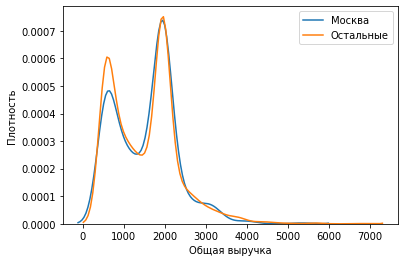

In [22]:
sns.distplot(
    total_in_month['total_revenue'][total_in_month['city']=='Москва'],
    hist = False, kde = True, label='Москва')

sns.distplot(    
    total_in_month['total_revenue'][total_in_month['city']!='Москва'],
    hist = False, kde = True, label='Остальные')

plt.legend()
plt.xlabel('Общая выручка')
plt.ylabel('Плотность')
plt.show() 

In [23]:
# видно, как близко идут значения. Дисперсии тоже близки, передадим параметр equal_var = True
results = st.ttest_ind(
    total_in_month['total_revenue'][total_in_month['city']=='Москва'], 
    total_in_month['total_revenue'][total_in_month['city']!='Москва'])

print('*********************')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

*********************
p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Нельзя сказать, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Это дает результат t-теста, и видно по гистограммам.

Получили у гистограмм по два ярко выраженных пика, значит, это бимодальные гистограммы. 

Во многих случаях это значит, что выборки происходят из двух разных популяций, так как наличие двух мод в одной популяции маловероятное явление

Разделим выборки по тарифам. Тогда можно будет работать дальше.

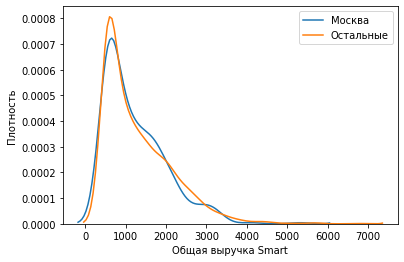

In [24]:
# тариф Smart
sns.distplot(
    total_in_month['total_revenue'][(total_in_month['city']=='Москва') & (total_in_month['tariff_name']=='smart')],
    hist = False, kde = True, label='Москва')

sns.distplot(    
    total_in_month['total_revenue'][(total_in_month['city']!='Москва') & (total_in_month['tariff_name']=='smart')],
    hist = False, kde = True, label='Остальные')

plt.legend()
plt.xlabel('Общая выручка Smart')
plt.ylabel('Плотность')
plt.show() 

Так лучше, хоть и со скошенностью вправо.

In [25]:
# видно, как близко идут значения. Дисперсии тоже близки, передадим параметр equal_var = True
results = st.ttest_ind(
    total_in_month['total_revenue'][(total_in_month['city']=='Москва') & (total_in_month['tariff_name']=='smart')], 
    total_in_month['total_revenue'][(total_in_month['city']!='Москва') & (total_in_month['tariff_name']=='smart')])

print('*********************')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

*********************
p-значение:  0.18150864159228705
Не получилось отвергнуть нулевую гипотезу


По тарифу Smart мы не можем сказать, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Это дает результат t-теста, да и видно по гистограммам.

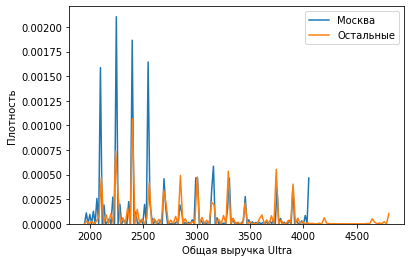

In [26]:
# тариф Ultra
sns.distplot(
    total_in_month['total_revenue'][(total_in_month['city']=='Москва') & (total_in_month['tariff_name']=='ultra')],
    hist = False, kde = True, label='Москва')

sns.distplot(    
    total_in_month['total_revenue'][(total_in_month['city']!='Москва') & (total_in_month['tariff_name']=='ultra')],
    hist = False, kde = True, label='Остальные')

plt.legend()
plt.xlabel('Общая выручка Ultra')
plt.ylabel('Плотность')
plt.show() 

По тарифу Ultra тот же результат. Мы не можем считать разными выручки и с этого тарифа по Москве и остальным городам.

## Общий вывод

* Первоначальное знакомство с данными показало, что:

   1. В большинстве таблиц необходимо заменить типы данных у некоторых столбцов, 
    
   2. А также нужно удалить дублирующий индексы столбец "Unnamed: 0" в таблице internet.
    
   3. Пропуски данных не обнаружены
   
* Предобработка данных привела к созданию датафрейма total_in_month, где рассчитано:

   1. количество сделанных звонков и израсходованных минут разговора по месяцам(calls_count и calls_sum);
   2. количество отправленных сообщений по месяцам(msg_count);
   3. объем израсходованного интернет-трафика по месяцам(internet_sum_gb Гбайт);
   4. помесячная выручка с каждого пользователя (вычли бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножили на значение из тарифного плана; прибавили абонентскую плату, соответствующую тарифному плану).
Здесь 3214 строк. Основной ключ это пара user_id и month.

Каждая строка отражает, какой тариф был у пользователя в этом месяце, сколько он потратил минут разговора, отправил сообщений, израсходовал трафика, и сколько превысил этих значений по своему тарифу, сколько переплатил и за что.

* Анализ данных дал средние, дисперсии и стандартные отклонения по 3 видам услуг.

    1. Меньше всего стандартные отклонения в трафике, больше всего - в исходящих сообщениях. Поэтому там мы еще посчитали медианное среднее.
    2. Ближе всего к нормальному распределение трафика, в звонках тоже распределение нормальное. А вот в сообщениях оно близко к Пуассоновскому.
    3. Все 3 случая показали, что плотность распределения выше в тарифе Smart, а разброс данных, сдвиг медианы и скошенность вправо - в тарифе Ultra.
    
* Проверка гипотез выявила, что:

    1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    2. Нельзя сказать, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.    